# Wavelength offset correction

The origin of small wavelength offsets in RSS data typically arises from several factors inherent in the observational and instrumental setup. These factors include slight misalignments or imperfections in the calibration process, such as errors in the wavelength calibration using reference lamps, and the finite precision of the spectrograph's grating or prism. Additionally, atmospheric effects, instrumental flexures, and variations in detector sensitivity can introduce minor shifts in the recorded wavelengths.

Measuring a wavelength offset between fibers can be done using several features:

- **Telluric Emission Lines**

The location of sky emission lines is constant across the entire field of view (FoV) and can be used as a reference system to anchor the relative offset between fibers. If the lines are identified, they can also provide an absolute offset. This method is very accurate but requires the presence of bright sky emission lines in all fibers, which becomes complicated in the presence of bright sources. Additionally, bright sky emission lines are typically detected beyond 5577 $\AA$ (corresponding to the auroral line produced by oxygen), making this method unsuitable for calibrating spectra in the blue region of the optical spectrum.

- **Telluric absorption lines**

Absorption lines produced by the atmosphere can also be used to anchor the relative offset between fibers, although their treatment is more complicated compared to individual (deblended) sky emission lines. However, these features are more easily detected in the presence of bright sources, complementing the previous method. Unfortunately, telluric absorption becomes prominent only at red wavelengths, offering little utility for the calibration of blue spectra.

- **Cross-correlation with some reference spectra**

An alternative method involves comparing fiber spectra with a reference spectrum. The most common approach is to use twilight exposures taken at sunset, which include the Sun's spectrum reflected by the atmosphere. This is then cross-correlated with a high-resolution solar spectrum, allowing for highly accurate estimation of absolute wavelength offsets. The downside of this approach is its limitation to a few exposures taken at very specific times. If variations are introduced during the rest of the night (e.g., changes in temperature, pointing-dependent instrumental flexures), this method may be unable to correct them.

In this tutorial, we will use a set of twilight flat frames to compute a wavelength offset correction by cross-correlating them with a solar reference spectrum. In subsequent tutorials, users will also have the opportunity to refine the wavelength solution of RSS data using sky emission lines.

## Data selection

The first step is to select the desired grating from the `/data/koala` directory

The `580V` grating extends from $\sim3700 \AA$ to $\sim6000\,\AA$, whereas the `385R` grating covers the wavelength range $\sim6000-9000\,\AA$

In [1]:
# Select the AAOMEGA grating (580V -> blue arm, 385R -> red arm)
aaomega_gratings = {'580V': 1, '385R': 2}
grating = '385R'

Let's now import the modules that will be required during the tutorial

In [2]:
import os
from matplotlib import pyplot as plt

from pykoala.instruments.koala_ifu import koala_rss
from pykoala.rss import combine_rss
from pykoala.corrections.wavelength import SolarCrossCorrOffset
from pykoala.plotting.utils import plot_fibres

In [3]:
help(SolarCrossCorrOffset)

Help on class SolarCrossCorrOffset in module pykoala.corrections.wavelength:

class SolarCrossCorrOffset(WavelengthCorrection)
 |  SolarCrossCorrOffset(sun_wavelength, sun_intensity, **kwargs)
 |  
 |  WavelengthCorrection based on solar spectra cross-correlation.
 |  
 |  This class constructs a WavelengthOffset and applies the resulting correction
 |  from a cross-correlation between a reference spectrum of the Sun and a twilight
 |  exposure, dominated by solar spectra features.
 |  
 |  Attributes
 |  ----------
 |  sun_intensity : np.ndarray
 |      Reference solar spectrum.
 |  sun_wavelength : np.ndarray
 |      Wavelength vector associated to ``sun_intensity``
 |  
 |  Method resolution order:
 |      SolarCrossCorrOffset
 |      WavelengthCorrection
 |      pykoala.corrections.correction.CorrectionBase
 |      abc.ABC
 |      pykoala.VerboseMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, sun_wavelength, sun_intensity, **kwargs)
 |      Init

Many corrections include factory methods that allow initialisation from files.

In [4]:
solar_correction = SolarCrossCorrOffset.from_fits()

## Prepare the input data

First, let's load the example twilight frames that we will use to compute the wavelength offset

In [5]:
rss = []
for i in [9, 10, 11, 12]:
    rss.append(
        koala_rss(
            os.path.join("..", "data", "koala", grating,
                         f"27feb{aaomega_gratings[grating]}00{i:02d}red.fits")
                         )
            )

[pykoala] 2024/10/27 15:59|INFO> 
> Reading KOALA RSS file 27feb20009red.fits
[pykoala] 2024/10/27 15:59|INFO> No. of fibres in this RSS =1000
No. of good fibres = 986
No. of bad fibres = 14
[pykoala] 2024/10/27 15:59|INFO> Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]
[pykoala] 2024/10/27 15:59|INFO> 
> Reading KOALA RSS file 27feb20010red.fits
[pykoala] 2024/10/27 15:59|INFO> No. of fibres in this RSS =1000
No. of good fibres = 986
No. of bad fibres = 14
[pykoala] 2024/10/27 15:59|INFO> Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]
[pykoala] 2024/10/27 15:59|INFO> 
> Reading KOALA RSS file 27feb20011red.fits
[pykoala] 2024/10/27 15:59|INFO> No. of fibres in this RSS =1000
No. of good fibres = 986
No. of bad fibres = 14
[pykoala] 2024/10/27 15:59|INFO> Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]
[pykoala] 2024/10/27 15:59|INFO> 
> Reading KOALA RSS file 27feb20012red.fit

  'Angstroms' -> 'Angstrom'. [astropy.wcs.wcs]
  'Angstroms' -> 'Angstrom'. [astropy.wcs.wcs]
  'Angstroms' -> 'Angstrom'. [astropy.wcs.wcs]
  'Angstroms' -> 'Angstrom'. [astropy.wcs.wcs]


Since we have four consecutive exposures, it is reasonable to assume that the wavelength offset remains the same in all individual frames. Then, we can combine the frames to increase the SNR and maximize the accuracy of our estimation.

To stack RSS data and create a master RSS file, pykoala provides a very simple tool called `combine_rss`. It takes as input a list of RSS and combines them according to a given input method. In our case, we will be using a simple mean.


In [6]:
stacked_rss = combine_rss(rss, combine_method='nanmean')

[pykoala] 2024/10/27 15:59|INFO> Combining input list of RSS data


/home/pcorchoc/Develop/koala/src/pykoala/rss.py:50: RuntimeWarning: Mean of empty slice
  new_intensity = combine_function(all_intensities, axis=0
/home/pcorchoc/Develop/koala/src/pykoala/rss.py:52: RuntimeWarning: Mean of empty slice
  new_variance = combine_function(all_variances, axis=0


We can quickly visualize the stacked data by using the RSS method `plot_rss_image`

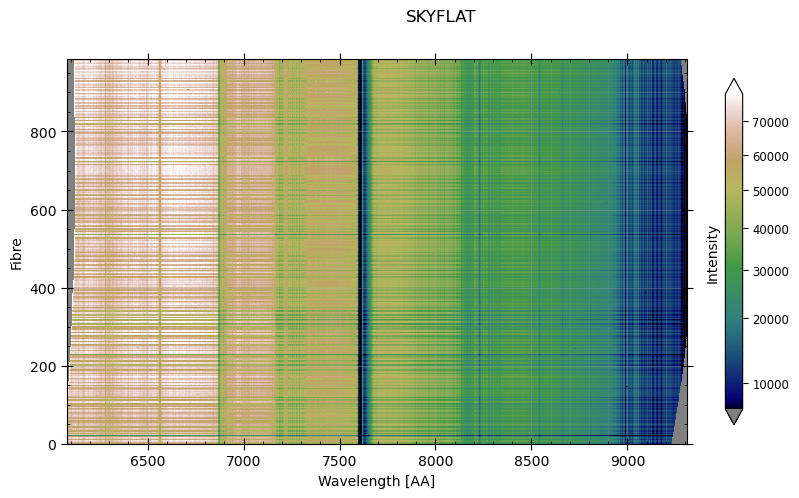

In [7]:
_ = stacked_rss.plot_rss_image()

## Estimating the wavelength offset from the master twilight

Once we have our input data ready, it is time for deriving the wavelength offset of each fibre.

This is implemented in pykoala via the method `compute_shift_from_twilight`, which performs a cross-correlation between the fibre specra of the input RSS and the solar reference spectra. Durnig the cross-correlation, this method also takes into account the line-spread-function of the instrument, modeled as a gaussian profile.

In order to maximize the performance of the cross-correlation, there are a few preparatory steps before performing the fit:

- After the reference solar spectra is interpolated to the RSS resolution, the method `get_solar_features` is called internally and it identifies regions dominated by absorption lines. An array of weights representing the prominence of absorption features is created. Usually, it is a good idea to clip a given fraction of pixels by setting their weights to zero, solely focusing on those sourrunding absorption lines. The parameter `keep_features_frac` can be used to vary such fraction (default is 5%). If users want to weight all pixels equally, they can provide a wavelength range (`wave_range`) and all
pixels within will be used.

- The input fibre spectra is not flux calibrated, and requires a previous renormalization to account for the spectrograph response function. This is achieved via a median filter, whose width is controlled with the parameter `response_window_size_aa`.

The cross-correlation is done by creating a grid of models with different offsets and LSF profiles. Users can provide both and array of shifts in pixels via `pix_shift_array`, as well as the values of $\sigma$ for the gaussian LSF using `pix_std_array`. Depending on the resolution of the instrument/grating, and the specific scientific goals, more or less points would be needed. For a reasonable previus wavelength calibration, offsets are tipically ranging between 2 to 3 pixels, while the instrumental LSF might extend a few pixels.

To control the performance of the fit, users might provide a list of fibre indices using the parameter `inspect_fibres`. For each of these fibres, a quality control plot will be created and returned as part of the solution.

In [8]:
solution = solar_correction.compute_shift_from_twilight(
    stacked_rss,
    keep_features_frac=0.05,  # fraction 
    pix_shift_array=np.arange(-2, 2, 0.20),
    pix_std_array=np.arange(0.5, 3, 0.20),
    logspace=False, inspect_fibres=[400, 500, 600])

[pykoala.correction.SolarCrossCorrelationOffset] 2024/10/27 15:59|INFO> Estimating regions of solar spectra dominated by absorption lines.
[pykoala.correction.SolarCrossCorrelationOffset] 2024/10/27 15:59|INFO> Number of pixels with non-zero weights: 1684 out of 2048
[pykoala.correction.SolarCrossCorrelationOffset] 2024/10/27 15:59|INFO> Including the masking of pixels dominated by telluric absorption
[pykoala.correction.SolarCrossCorrelationOffset] 2024/10/27 15:59|INFO> Computing grid of solar spectra models
[pykoala.correction.SolarCrossCorrelationOffset] 2024/10/27 15:59|INFO> Performing the cross-correlation with the grid of models
[pykoala.correction.SolarCrossCorrelationOffset] 2024/10/27 15:59|INFO> Inspecting input fibre: 400
[pykoala.correction.SolarCrossCorrelationOffset] 2024/10/27 15:59|INFO> Inspecting input fibre: 500
[pykoala.correction.SolarCrossCorrelationOffset] 2024/10/27 15:59|INFO> Inspecting input fibre: 600
[pykoala.correction.SolarCrossCorrelationOffset] 2024/1

/home/pcorchoc/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


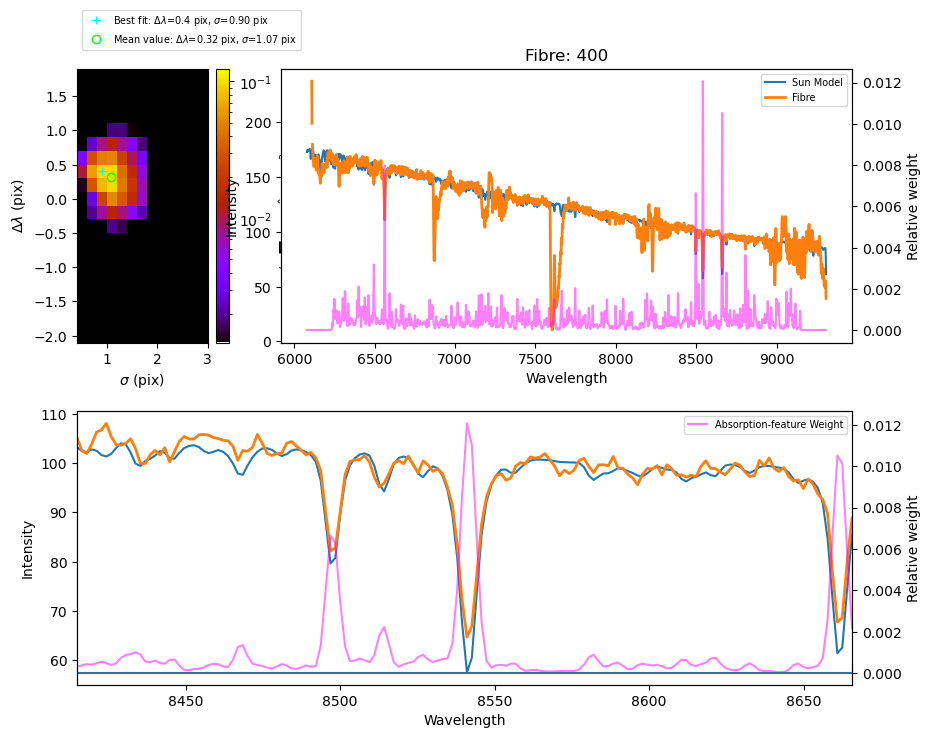

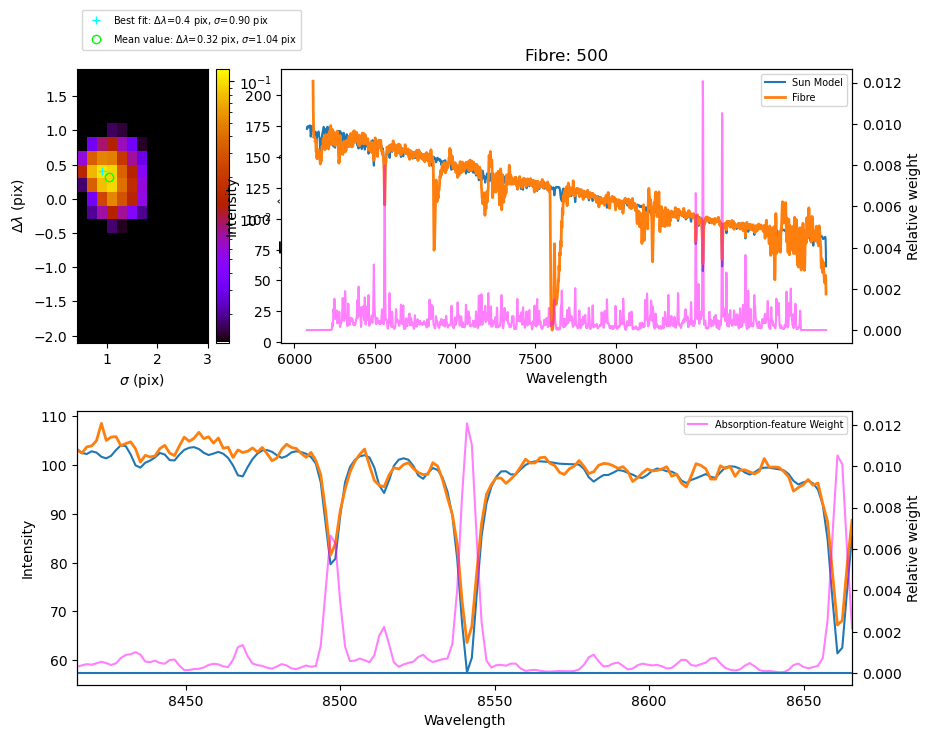

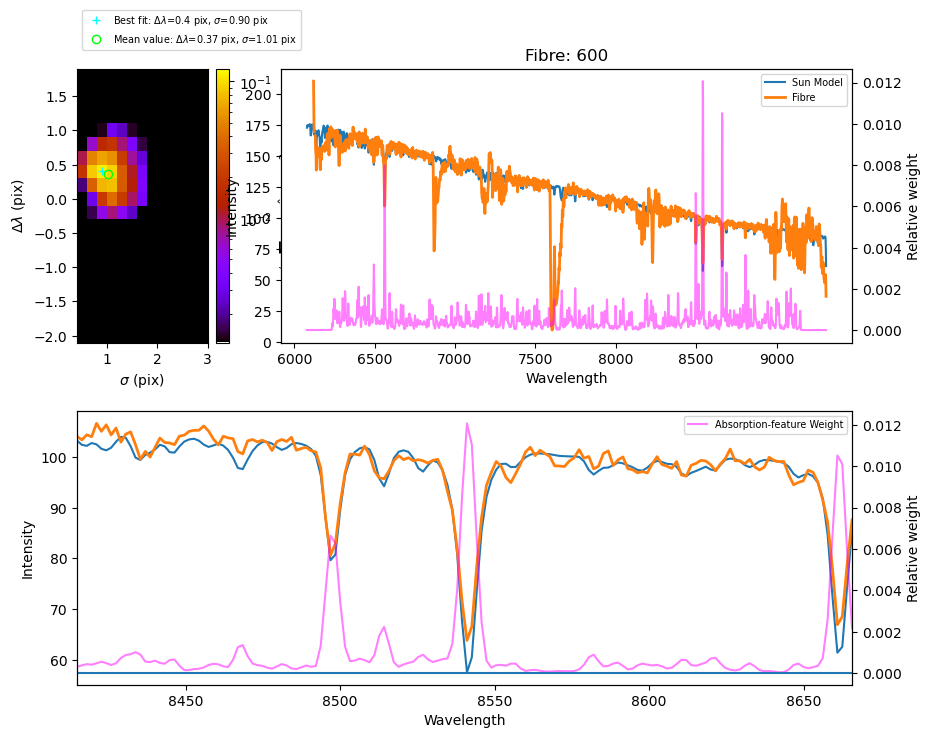

In [12]:
# Reopen the figures
for fig in solution['fibre_figures']:
 fig = plt.figure(fig)
 plt.show()

In the above plots, you can see several panels. The top-right panel shows the renormalized fibre spectra plotted together with the reference solar spectrum. The fuchsia line represents the relative weights assigned to each pixel.

The bottom panel displays a zoom-in around the most prominent absortion lines relative to the continuum. Depending on the grating chosen for this tutorial, users might find the region around the Ca H and K lines for the `580V` grating, whereas `385R` data would center around the CaIII in the near IR.

The top-left plot shows the likelihood distribution in terms of wavelength shift and LSF $\sigma$, including the best fit and mean values.

We can have a look at the resulting offset as function of fibre position

/home/pcorchoc/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


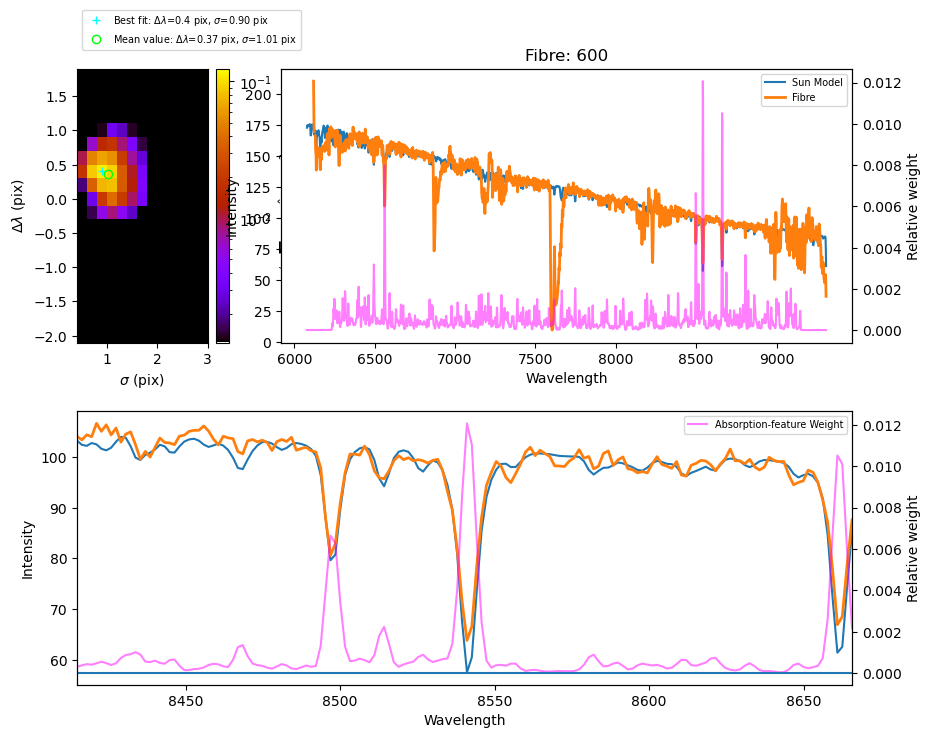

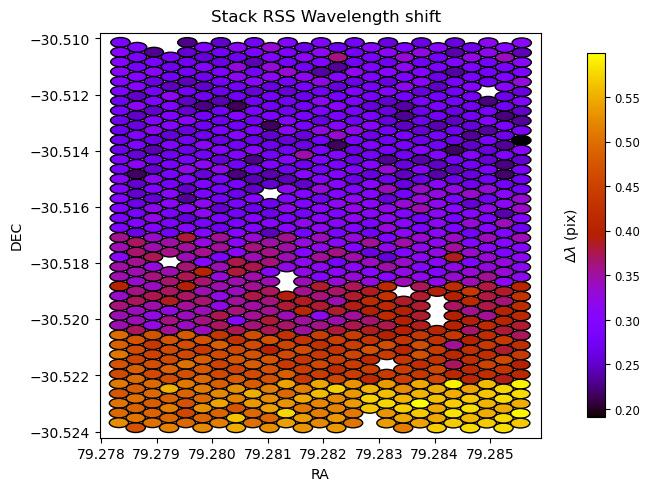

In [10]:
fig, ax = plt.subplots(constrained_layout=True)
fig.suptitle("Stack RSS Wavelength shift")
ax.set_xlabel("RA")
ax.set_ylabel("DEC")
_ = plot_fibres(fig, ax, rss=stacked_rss, data=solution['mean'][0], norm=plt.Normalize(),
            cmap='gnuplot', cblabel=r'$\Delta\lambda$ (pix)')

By default, after performing the cross-correlation, the correction will use the best fit offset values to create the `offset`. We can save this offset into a FITS file, so we can apply it later to other datasets.


In [13]:
solar_correction.offset.to_fits(
    os.path.join("..", "products", "koala", grating, "wavelength_offset.fits"))

[pykoala] 2024/10/27 16:04|INFO> Wavelength offset saved at ../products/koala/385R/wavelength_offset.fits
